## Training a deep learning model to recognise shrubs

With the training data we created in the previous notebook, we'll train a deep learning model to find shrub outlines in drone imagery.

* Train a basic model
* Visualise the training with Tensorboard
* Test the model and look at its performance

In [ ]:
%pip install git+https://github.com/MAMBO-Horizon-WP4/attn-unet-shrub-id.git

Import the code we're going to be using - the Pytorch framework for deep learning model training, Tensorboard to record metrics and build visualisations, and the code we just installed from [attn-unet-shrub-id](https://github.com/MAMBO-Horizon-WP4/attn-unet-shrub-id)

In [ ]:
import glob
import torch
import rasterio
from datetime import datetime
from rasterio.plot import reshape_as_image
from shrubnet.model import AttentionUNet
from shrubnet.train import train_model
from shrubnet.dataset import RSDataset

## Training and fine-tuning a model

For training a model (either starting from random weights or an existing set of trained weights) we need a set of image pairs - an RGB image and a mask showing where shrubs are, or aren't.

We can use the previous notebook to prepare its data, or run the same functions as a pipeline from the [shrub-prepro](https://github.com/MAMBO-Horizon-WP4/shrub-prepro) repository.

Let's look at some examples of what it produces. First read the list of files in our training data:



In [ ]:
!unzip /content/drive/MyDrive/mambo_data/shrub_training_data_ok.zip

Archive:  /content/drive/MyDrive/mambo_data/shrub_training_data_ok.zip
replace shrub_training_data/train/images/shrubs_207.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

The training will be a LOT faster if we use a GPU to run it.

In Colab, you might need to select the drop-down on the right hand side (where it says "RAM" and "Disk") and "_Change runtime type_" to be **T4 GPU**.

Run the cell below:
* `device(type='cuda')` means we've got access to a GPU.
* `device(type='cpu')` means we should change the runtime.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

We create an empty model and send it to the GPU

In [ ]:
model = AttentionUNet().to(device)

_For now upload a zipfile, if data ok then add to the repo_

In [ ]:
!unzip /content/drive/MyDrive/mambo_data/shrub_training_data_ok.zip

In [ ]:
images_dir = 'shrub_training_data/train/images/'
labels_dir = 'shrub_training_data/train/labels/'
images = glob.glob(f'{images_dir}*.tif')
labels = glob.glob(f'{labels_dir}*.tif')

In [ ]:
#images = s3.ls('s3://attn-unet-shrub-id/data/train/images')
#labels = s3.ls('s3://attn-unet-shrub-id/data/train/labels')

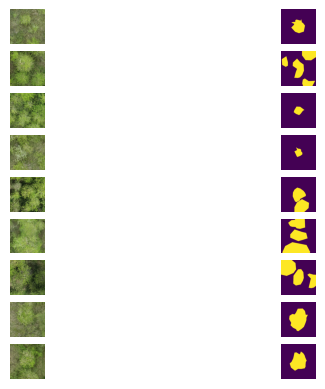

In [ ]:
from matplotlib import pyplot as plt

previews = []
for i in range(0,9):
    #previews.append(rasterio.open('s3://'+images[i]).read())
    #previews.append(rasterio.open('s3://'+labels[i]).read())
    previews.append(rasterio.open(images[i]).read())
    previews.append(rasterio.open(labels[i]).read())
fig, axes = plt.subplots(int(len(previews)/2), 2, sharex=True, sharey=True)

for img, ax in zip(previews, axes.flat):
    ax.imshow(reshape_as_image(img))
    ax.axis('off')

Split that dataset into a part used for training, and a part used for validation - measuring how well our model is doing

In [ ]:
dataset = RSDataset(images_dir, labels_dir)

In [ ]:
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


Before we start our experiment we'll set up Tensorboard. This will record the metrics and provide a nice visualisation of how our training has gone

In [ ]:

from tensorflow import summary
%load_ext tensorboard
current_time = str(datetime.now().timestamp())
train_log_dir = 'logs/tensorboard/train/' + current_time
test_log_dir = 'logs/tensorboard/test/' + current_time
train_summary_writer = summary.create_file_writer(train_log_dir)
val_summary_writer = summary.create_file_writer(test_log_dir)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF']="expandable_segments:True"

In [ ]:
epochs = 5 # Just to see it running. We probably want at least 50, and metrics for evidence
batch_size = 1 # Reduced batch size further
learning_rate = 0.00001 # Tune this by trial and error. There are also techniques for changing it over time
accumulation_steps = 8 # Increased accumulation steps

torch.cuda.empty_cache() # Clear CUDA cache

trained_model = train_model(
      model=model,
      train_dataset=train_dataset,
      val_dataset=val_dataset,
      epochs=epochs,
      batch_size=batch_size,
      lr=learning_rate,
      accumulation_steps=accumulation_steps,
      device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
      train_summary_writer=train_summary_writer,
      val_summary_writer=val_summary_writer
)

Epoch 1/5:   0%|          | 0/316 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 32.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 10.12 MiB is free. Process 173039 has 14.73 GiB memory in use. Of the allocated memory 14.56 GiB is allocated by PyTorch, and 56.78 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)